# Four-Channel WDM Filter

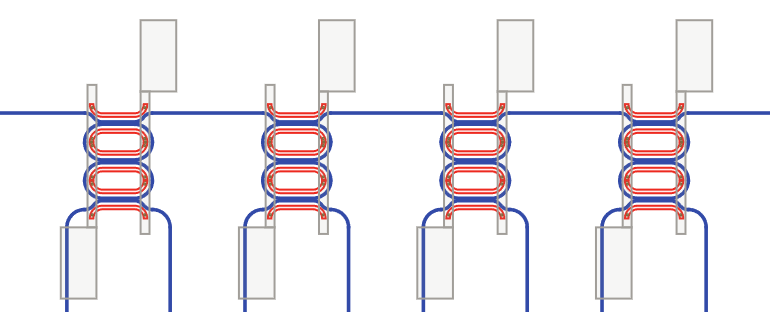

In this notebook, we replicate the design and simulation results of a robust, fabrication-tolerant four-channel wavelength-division multiplexing (WDM) filter demonstrated in [1]. The filter is implemented using silicon-based microring resonators, specifically leveraging both single-ring resonators (1RR) and cascaded double-ring resonators (2RR). These structures exhibit distinct spectral responses, insertion losses, and crosstalk performance, which we compare through detailed electromagnetic simulations.

We systematically walk through the design process:

- Defining the silicon photonics technology with precise materials, layers, and fabrication parameters.
- Constructing and characterizing basic photonic components such as directional couplers, waveguides, and bends.
- Assembling single-ring (1RR) and double-ring (2RR) resonator filters, then cascading these components to form complete four-channel WDM multiplexers.
- Simulating and visualizing the scattering matrix (S-matrix) responses.

**Reference**:

1. De Heyn, P., et al., "Fabrication-Tolerant Four-Channel Wavelength-Division-Multiplexing Filter Based on Collectively Tuned Si Microrings," *Journal of Lightwave Technology*, 2013 31 (16), 2785–2792, doi: [10.1109/JLT.2013.2273391](https://doi.org/10.1109/JLT.2013.2273391).






In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import tidy3d as td
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer(port=5003)
wavelengths = np.linspace(1.543, 1.558, 201)

Starting live viewer at http://localhost:5003


## Defining the Technology Stack

We define a custom silicon photonics technology, closely following the parameters described in the paper. The technology includes specifications for various materials and layers, such as silicon waveguides, silicon slabs, p-doped silicon regions, tungsten vias, and aluminum metal interconnects. Each layer has clearly defined thicknesses, materials, and visual properties suitable for accurate 3D simulation and visualization. The waveguide geometry is specifically chosen to reproduce the dimensions provided in the referenced design.


In [2]:
@pf.parametric_technology
def iSiPP_technology(
    *,
    si_thickness=0.22,
    si_slab_thickness=0.22 - 0.07,
    via_thickness=0.8,
    metal_thickness=0.4,
    si=td.material_library["cSi"]["Palik_Lossless"],
    si_doping=td.Medium(permittivity=3.485**2),
    sio2=td.material_library["SiO2"]["Palik_Lossless"],
    tungsten=td.material_library["W"]["RakicLorentzDrude1998"],
    metal=td.material_library["Al"]["RakicLorentzDrude1998"]
):
    """
    Defines the iSiPP technology stack with material properties, layers, and
    3D extrusion specifications for silicon photonic components.

    Parameters:
    - si_thickness: Silicon thickness in µm
    - si_slab_thickness: Slab thickness in µm
    - via_thickness: Thickness of tungsten via layer in µm
    - metal_thickness: Thickness of top metal layer in µm
    - si: Undoped crystalline silicon material
    - si_doping: P-doped silicon material
    - sio2: Oxide cladding material
    - tungsten: Metal for via
    - metal: Top metal interconnect layer (aluminum)
    """

    # Layer definitions with visual properties
    layers = {
        "Si": pf.LayerSpec((1, 0), description="Si", color="#324aa818", pattern="/"),
        "Si Slab": pf.LayerSpec(
            (2, 0), description="Si Slab", color="#5c74d118", pattern="//"
        ),
        "Si P-doping": pf.LayerSpec(
            (3, 0), description="Si P-doping", color="#ed291f18", pattern="//"
        ),
        "Tungsten Via": pf.LayerSpec(
            (10, 0), description="Tungsten Via", color="#80653718", pattern="//"
        ),
        "M1": pf.LayerSpec((11, 0), description="M1", color="#a19e9918", pattern="//"),
    }

    # Mask definitions
    si_mask = pf.MaskSpec((1, 0))
    si_slab_mask = pf.MaskSpec((2, 0))
    si_doping_mask = pf.MaskSpec((3, 0))
    via_mask = pf.MaskSpec((10, 0), (11, 0), "*")
    metal_mask = pf.MaskSpec((11, 0))

    # Visualization colors for 3D model rendering
    si = si.updated_copy(viz_spec=td.VisualizationSpec(facecolor="#324aa8", alpha=1))
    sio2 = sio2.updated_copy(
        viz_spec=td.VisualizationSpec(facecolor="#dff7f7", alpha=0.8)
    )
    si_doping = si_doping.updated_copy(
        viz_spec=td.VisualizationSpec(facecolor="#ed291f", alpha=1)
    )

    # Vertical extrusion heights
    z_via = si_thickness
    z_metal = z_via + via_thickness

    # Extrusion specifications
    extrusion_specs = [
        pf.ExtrusionSpec(
            si_mask, limits=(0, si_thickness), medium=si, sidewall_angle=0
        ),
        pf.ExtrusionSpec(
            si_slab_mask, limits=(0, si_slab_thickness), medium=si, sidewall_angle=0
        ),
        pf.ExtrusionSpec(
            si_doping_mask, limits=(0, si_thickness), medium=si_doping, sidewall_angle=0
        ),
        pf.ExtrusionSpec(
            via_mask,
            limits=(z_via, z_via + via_thickness),
            medium=tungsten,
            sidewall_angle=0,
        ),
        pf.ExtrusionSpec(
            metal_mask,
            limits=(z_metal, z_metal + metal_thickness),
            medium=metal,
            sidewall_angle=0,
        ),
    ]

    # Port specification
    ports = {
        "Strip_450": pf.PortSpec(
            description="Strip waveguide, TE, 450 nm wide",
            width=2,
            limits=(-1, 1.22),
            num_modes=1,
            target_neff=3.5,
            path_profiles=[(0.45, 0, (1, 0))],
        )
    }

    # Technology object
    tech = pf.Technology(
        name="iSiPP",
        version="1.0",
        layers=layers,
        extrusion_specs=extrusion_specs,
        ports=ports,
        background_medium=sio2,
    )

    return tech


We instantiate the defined technology, set it as the default technology for PhotonForge, and configure general simulation parameters such as the default mesh refinement and port specifications. We also set the Tidy3D logging level to `"ERROR"` to reduce non-essential output during simulation. However, users should always run with all warnings enabled when working on a new project and only suppress them once they have verified that the warnings are understood and can be safely ignored.


In [3]:
# Instantiate the defined iSiPP technology
tech = iSiPP_technology()

# Set Tidy3D logging level to reduce verbosity (enable full warnings when debugging new projects)
td.config.logging_level = "ERROR"

# Set the iSiPP technology as the default for PhotonForge
pf.config.default_technology = tech

# Define default mesh refinement level for simulations
pf.config.default_mesh_refinement = 15

# Extract port specification from technology definition
port_spec = tech.ports["Strip_450"]

# Configure default keyword arguments for PhotonForge components
pf.config.default_kwargs = {"port_spec": port_spec}

tech

Name: iSiPP
Version: 1.0

Layers:
    Name       Layer   Description     Color    Pattern
-------------------------------------------------------
Si             (1, 0)  Si            #324aa818     /   
Si Slab        (2, 0)  Si Slab       #5c74d118     //  
Si P-doping    (3, 0)  Si P-doping   #ed291f18     //  
Tungsten Via  (10, 0)  Tungsten Via  #80653718     //  
M1            (11, 0)  M1            #a19e9918     //  

Extrusion Specs:
#           Mask          Limits (μm)  Sidewal (°)            Opt. Medium                       Elec. Medium          
----------------------------------------------------------------------------------------------------------------------
0  'Si'                     0, 0.22         0       cSi_PalikLossless                 cSi_PalikLossless               
1  'Si Slab'                0, 0.15         0       cSi_PalikLossless                 cSi_PalikLossless               
2  'Si P-doping'            0, 0.22         0       Medium(viz_spec={'attrs': {}, '…  Medium(viz_spec={'attrs': {}, '…
3  'Tungsten Via' * 'M1'   0.22, 1.02       0       W_RakicLorentzDrude1998           W_RakicLorentzDrude1998         
4  'M1'                    1.02, 1.42       0       Al_RakicLorentzDrude1998          Al_RakicLorentzDrude1998        

Ports:
   Name    Classification            Description             Width (μm)  Limits (μm)  Radius (μm)  Modes  Target n_eff  Path profiles (μm)  Voltage path  Current path
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Strip_450     optical      Strip waveguide, TE, 450 nm wide      2         -1, 1.22        0         1        3.5       'Si': 0.45                                    

Background medium:
- Optical: SiO2_Palik_Lossless
- Electrical: SiO2_Palik_Lossless

Connections: []

## Inspecting the Port Mode

We inspect the fundamental transverse electric (TE) mode of our waveguide to ensure that the mode profile is accurately confined and sufficiently small at the simulation domain boundaries. We use a higher mesh refinement for increased accuracy. The resulting electric field distribution and mode parameters confirm the desired mode characteristics.


Loading cached simulation from .tidy3d/pf_cache/KI7/ms_info-S3CMKWEUFP7BZ43F5QD4BWZ3UREK4Y6APLFXQTCINZ64YOUTYHXQ.json.


Progress: 100%


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.353273    0.0          0.976572   

                         wg TE fraction  wg TM fraction  mode area  \
f            mode_index                                              
1.934145e+14 0                 0.728758        0.819755     0.1978   

                         group index  dispersion (ps/(nm km))  
f            mode_index                                        
1.934145e+14 0              4.275892               499.962409

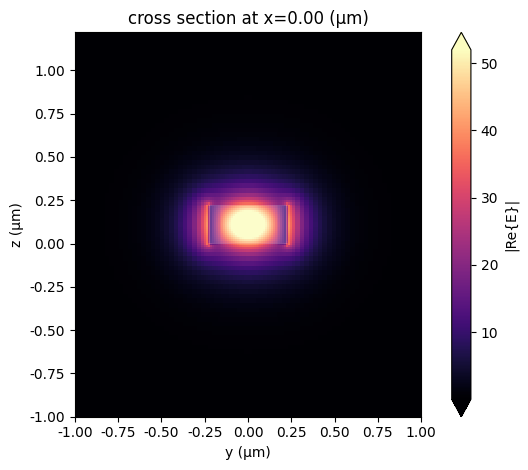

In [4]:
# Solve for port modes at the waveguide input port (P0)
mode_solver = pf.port_modes(
    port_spec,  # Port specification
    frequencies=[pf.C_0 / 1.55],  # Frequency corresponding to λ=1.55 µm
    mesh_refinement=40,  # High mesh refinement for accurate mode profile
    group_index=True,  # Calculate the mode's group index
)

# Plot the electric field distribution (TE mode, mode_index=0)
_ = mode_solver.plot_field("E", mode_index=0, f=pf.C_0 / 1.55)

# Export the calculated mode data to a DataFrame for inspection
mode_solver.data.to_dataframe()

## Device layout

### Directional Coupler Definition

We define directional couplers essential for our ring-based WDM circuits. The couplers are configured to support both bus-to-ring and ring-to-ring coupling with specified parameters, including coupling gap, radius, coupling length, doping areas for heaters, and tungsten vias for electrical connections. The device layout also incorporates necessary doping paths for heater implementation, providing thermal tuning capability as described in the reference paper.


In [5]:
wg_width, _ = port_spec.path_profile_for("Si")


def directional_coupler(
    *,
    coupling_gap=0.340,  # Gap between waveguides (µm)
    radius=5,  # Bend radius (µm)
    coupling_length=9,  # Length of the coupling region (µm)
    doping_offset=1.2,  # Offset of doping region from waveguide edge (µm)
    heater_width=1.0,  # Width of heater doping region (µm)
    type="ring_to_ring"  # Coupler type: "ring_to_ring" or "bus_to_ring"
):

    if type == "bus_to_ring":
        # Directional coupler configuration for bus-to-ring coupling
        component = pf.parametric.s_bend_ring_coupler(
            coupling_distance=wg_width + coupling_gap,
            radius=radius,
            coupling_length=coupling_length,
            s_bend_length=radius,
            s_bend_offset=port_spec.width,
        )
    else:
        # Directional coupler configuration for ring-to-ring coupling
        component = pf.parametric.dual_ring_coupler(
            coupling_distance=wg_width + coupling_gap,
            radius=radius,
            coupling_length=coupling_length,
        )

    # Compute doping region positions for heaters (first doping area)
    port1 = np.array(component.ports["P1"].center) + (
        (heater_width + wg_width) / 2.0 + doping_offset,
        0,
    )

    # Compute doping region positions for heaters (second doping area)
    port3 = np.array(component.ports["P3"].center) + (
        -(heater_width + wg_width) / 2.0 - doping_offset,
        0,
    )

    # Radius calculation for doping region paths
    doping_radius = radius - heater_width / 2.0 - wg_width / 2.0 - doping_offset

    # First doping path construction (arc + straight segment + turn)
    doping1 = (
        pf.Path(port1, heater_width)
        .arc(180, 180 + 90, radius=doping_radius)  # Arc from 180° to 270° CCW
        .segment((coupling_length, 0), relative=True)
    ).turn(90, radius=doping_radius)

    # Compute vertical offset between doping paths
    vertical_offset = (
        -2 * doping_radius
        - heater_width
        - 2 * doping_offset
        - 2 * wg_width
        - coupling_gap
    )

    # Second doping path (mirrored and translated from the first)
    doping2 = doping1.copy().rotate(180).translate((0, vertical_offset))

    # Add doping regions to component
    component.add("Si P-doping", doping1, doping2)

    # Add tungsten vias at doping region ends for electrical contacts
    via0 = pf.Circle(radius=0.2, center=port1)
    via1 = pf.Circle(radius=0.2, center=port1 + (0.2, -1))
    via2 = pf.Circle(radius=0.2, center=port1 + (0.2, vertical_offset + 1))
    via3 = pf.Circle(radius=0.2, center=port3)
    via4 = pf.Circle(radius=0.2, center=port3 + (-0.2, -1))
    via5 = pf.Circle(radius=0.2, center=port3 + (-0.2, vertical_offset + 1))
    component.add("Tungsten Via", via0, via1, via2, via3, via4, via5)

    # Define port symmetries for Tidy3D simulations
    if type == "ring_to_ring":
        component.models["Tidy3D"].port_symmetries = [
            ("P1", "P0", "P3", "P2"),  # x-axis reflection
            ("P2", "P3", "P0", "P1"),  # y-axis reflection
            ("P3", "P2", "P1", "P0"),  # inversion symmetry
        ]

    return component

In [6]:
# Instantiate a directional coupler with 340 nm gap for 2RR configuration
dc_2rr = directional_coupler(coupling_gap=0.340)

# Test the defined port symmetries (assert if test fails)
assert dc_2rr.active_model.test_port_symmetries(
    dc_2rr, frequencies=[pf.C_0 / 1.55], grid_spec=8
)

# Visualize the resulting layout
viewer(dc_2rr)

Loading cached simulation from .tidy3d/pf_cache/OTB/fdtd_info-RRMERNXB3DKVK6N23OKWFFEQVVS3WAWX5SJ36JVZXNJ6LLY65PKQ.json.


Loading cached simulation from .tidy3d/pf_cache/OTB/fdtd_info-VWWU5C5ZM5ZM3F47BLKR3OHMM3Y77MGNBYGOT4577CIMUBZWOGAA.json.
Loading cached simulation from .tidy3d/pf_cache/OTB/fdtd_info-3VTAP6XRZU5TIZXDDYS4JCORGWV3YGM6ZD4IW4PGW5I6XNYPA5QQ.json.
Loading cached simulation from .tidy3d/pf_cache/OTB/fdtd_info-2EVPZD3YGOCFFX2OAQK3MWYX5NPPOUO7MSGCRMW7NM42OSIUZ7NQ.json.


Progress: 100% 
Progress: 100% 


In [7]:
# Instantiate a directional coupler with 205 nm gap for bus-to-ring coupling
dc_2br = directional_coupler(coupling_gap=0.205, type="bus_to_ring")

# Display the component layout
viewer(dc_2br)

### The 1RR Single Resonator Filter

We construct a single-ring resonator (1RR) filter by connecting two identical bus-to-ring directional couplers in a loop. The port mapping enables both through and drop functionality. The layout is visualized to verify the closed-loop structure of the resonator.


In [8]:
@pf.parametric_component
def filter_1rr(*, coupling_length=9.0, radius=5, coupling_gap=0.295):
    # Create two identical bus-to-ring directional couplers
    dc_1rr = directional_coupler(
        coupling_length=coupling_length,
        radius=radius,
        coupling_gap=coupling_gap,
        type="bus_to_ring",
    )

    # Define netlist connecting the couplers into a single-ring resonator
    netlist_1RR = {
        "name": "1RR Filter",
        "instances": [dc_1rr, dc_1rr],  # Two identical couplers
        "connections": [((1, "P1"), (0, "P3"))],  # Connect inner ports to form a loop
        "ports": [  # Define external ports
            (0, "P0"),  # Input
            (1, "P2"),  # Drop
            (0, "P2"),  # Through
            (1, "P0"),  # Add port for symmetry or test
        ],
        "models": [pf.CircuitModel()],  # Attach default model
    }

    return pf.component_from_netlist(netlist_1RR)  # Return the assembled component


# Instantiate and visualize the single-ring filter layout
one_rr = filter_1rr()
viewer(one_rr)

We compute the frequency-domain scattering matrix of the 1RR filter across the specified wavelength range. The results are plotted on a decibel scale to reveal the spectral response at the drop and through ports when light is injected into port P0. For comparison, we also overlay a measured spectrum from [1]. The measured wavelengths have been slightly shifted to align the resonance position with that of our simulated structure.


Loading cached simulation from .tidy3d/pf_cache/4CG/fdtd_info-SYE2NYMKRMOTUV2G32BDHSO3DJMFBUGQIJ7OZKRGNGDUVH5XDKPQ.json.


Loading cached simulation from .tidy3d/pf_cache/4CG/fdtd_info-DM2VARW3MDAYSERBB5JUQG5KYAF62XHP4ECIAT3QYL7RJRVXUKHA.json.
Loading cached simulation from .tidy3d/pf_cache/4CG/fdtd_info-CFDWPR3HLY3UCBKEJ76YCGRFLAYGSAAPY6ZR3BTJBWBMJBFE2QPA.json.
Loading cached simulation from .tidy3d/pf_cache/4CG/fdtd_info-344EJ4RER3X4YDOKWRKIO276SCC6BTYPRJ6XVPK2IAF2R5TTCVNA.json.


Loading cached simulation from .tidy3d/pf_cache/NOI/ms_info-VMFCPGQ64JIYOB4XPQ6U7RGY7X6EP3N5BX5T2YYPOWBXYM4G2SIA.json.
Loading cached simulation from .tidy3d/pf_cache/2LR/ms_info-RZFSA4RVOYZJDS2ASQ6UC5BBJ3QJ6NAMH4RF7657QLY2OOYSCN6A.json.
Loading cached simulation from .tidy3d/pf_cache/ZVD/ms_info-UBHTNNT3P5SCDLPZPHLKXZLKCKYJQ23HY33RP4UJOFNCWTQORLBQ.json.
Loading cached simulation from .tidy3d/pf_cache/ZGB/ms_info-BE6OMNPET53JWRDELZQ4EXG7BAZOJEVRP44MGTTKC5S5CNL6Z76A.json.


Progress: 100% 


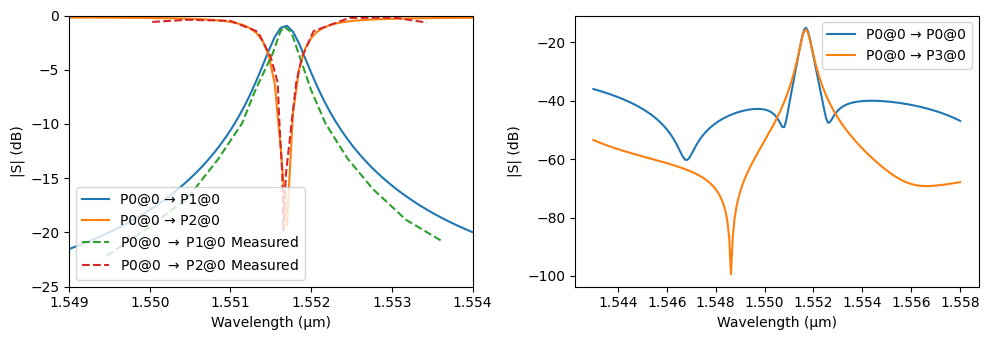

In [9]:
# Measurement data
s10_measured = np.array(
    [
        [1.537840, -22.136],
        [1.538349, -19.583],
        [1.538836, -16.838],
        [1.539209, -13.325],
        [1.539513, -9.957],
        [1.539679, -6.878],
        [1.539891, -3.559],
        [1.539986, -1.539],
        [1.540033, -1.010],
        [1.540124, -1.537],
        [1.540213, -3.460],
        [1.540369, -6.872],
        [1.540548, -9.947],
        [1.540819, -13.165],
        [1.541136, -15.999],
        [1.541546, -18.832],
        [1.541980, -20.750],
    ]
)

s20_measured = np.array(
    [
        [1.538401, -0.593],
        [1.538838, -0.396],
        [1.539367, -0.487],
        [1.539710, -1.493],
        [1.539868, -3.800],
        [1.539956, -6.203],
        [1.539974, -9.472],
        [1.540012, -14.615],
        [1.540027, -19.808],
        [1.540058, -14.615],
        [1.540135, -9.422],
        [1.540186, -6.152],
        [1.540258, -3.796],
        [1.540400, -1.439],
        [1.540839, -0.233],
        [1.541390, -0.179],
        [1.541804, -0.656],
    ]
)

# Simulate the S-matrix over the defined wavelength range
s_matrix_1rr = one_rr.s_matrix(frequencies=pf.C_0 / wavelengths)

# Plot S-matrix in dB scale with P0 as the input port
fig, axes = pf.plot_s_matrix(s_matrix_1rr, y="dB", input_ports=["P0"])

# Overlay measurement data with dashed line
# The resonance wavelength is shifted to match simulation
axes[0].plot(
    s10_measured[:, 0] + 0.01163,
    s10_measured[:, 1],
    "--",
    label=r"P0@0 $\rightarrow$ P1@0 Measured",
)
axes[0].plot(
    s20_measured[:, 0] + 0.01163,
    s20_measured[:, 1],
    "--",
    label=r"P0@0 $\rightarrow$ P2@0 Measured",
)

axes[0].set_xlim([1.549, 1.554])
axes[0].set_ylim([-25, 0])
axes[0].legend(loc="lower left")

### Assembling a 4-Channel 1RR-Based WDM Filter

We build a four-channel WDM filter by cascading four 1RR filters with increasing ring circumference. The coupling length is incremented in steps to shift the resonance of each ring. Straight waveguides are inserted between adjacent rings to complete the bus structure. The resulting multiplexer layout is returned for visualization.


In [10]:
# Define ring length increment parameters
added_length = 0.075
coupling_length = 9

# Define a straight waveguide and a bend components for circuit use
wg = pf.parametric.straight(length=31)
bend = pf.parametric.bend(name="Bend", radius=5)

# Create four 1RR filters with increasing coupling lengths
one_rr_0 = filter_1rr(coupling_length=coupling_length)
one_rr_1 = filter_1rr(coupling_length=coupling_length + added_length)
one_rr_2 = filter_1rr(coupling_length=coupling_length + 2 * added_length)
one_rr_3 = filter_1rr(coupling_length=coupling_length + 3 * added_length)

# Create a netlist describing the 4-channel 1RR multiplexer circuit
netlist = {
    "name": "4-Channel MUX 2RR",
    "instances": {
        "1rr0": one_rr_0,  # First ring
        "1rr1": one_rr_1,  # Second ring
        "1rr2": one_rr_2,  # Third ring
        "1rr3": one_rr_3,  # Fourth ring
        "wg0": wg,  # Bus segment between ring 0 and 1
        "wg1": wg,  # Bus segment between ring 1 and 2
        "wg2": wg,  # Bus segment between ring 2 and 3
    },
    "connections": [
        (("wg0", "P0"), ("1rr0", "P3")),  # Connect ring 0 to ring 1 via wg0
        (("1rr1", "P1"), ("wg0", "P1")),
        (("wg1", "P0"), ("1rr1", "P3")),  # Connect ring 1 to ring 2 via wg1
        (("1rr2", "P1"), ("wg1", "P1")),
        (("wg2", "P0"), ("1rr2", "P3")),  # Connect ring 2 to ring 3 via wg2
        (("1rr3", "P1"), ("wg2", "P1")),
    ],
    "ports": [  # Expose ports for drop, input, and through for all rings
        ("1rr0", "P1"),
        ("1rr0", "P0"),
        ("1rr0", "P2"),
        ("1rr1", "P0"),
        ("1rr1", "P2"),
        ("1rr2", "P0"),
        ("1rr2", "P2"),
        ("1rr3", "P0"),
        ("1rr3", "P2"),
        ("1rr3", "P3"),
    ],
    "models": [pf.CircuitModel()],
}

# Generate the 4-channel multiplexer component from the netlist
mux_1rr = pf.component_from_netlist(netlist)
viewer(mux_1rr)

Loading cached simulation from .tidy3d/pf_cache/KCL/fdtd_info-VEE4RSW2TMRPHXBYV4KHH26ESXJNUHUHIMDLSMHEIEOA7FFE4KTA.json.
Loading cached simulation from .tidy3d/pf_cache/KCL/fdtd_info-HR5UBV5N2A53JBTISS64TS3J7MGKPL4HO6DY5LIVBIAG2SY74VBA.json.


Loading cached simulation from .tidy3d/pf_cache/KCL/fdtd_info-4W7NGIZ4EIFHF57FVTNUBESZ5NQ7HDCEVYNP5VKGGBE3JAC7SQ4Q.json.
Loading cached simulation from .tidy3d/pf_cache/KCL/fdtd_info-DBU56AZCEDLZUNNYRBLRB2LFASQZMRFSOL2EXXKLN3A4KGVTDONA.json.


Loading cached simulation from .tidy3d/pf_cache/KJY/fdtd_info-T7PI67F7GSZDDQGKIJTA7E3K4PPPSNQFKQVKSEVI2U5JV5EIXRAA.json.
Loading cached simulation from .tidy3d/pf_cache/KJY/fdtd_info-BRRVBQJV4NUZ5H6ULOBODQGNQWI3UQK4RYYGIZIILGDIMIGQMK5Q.json.
Loading cached simulation from .tidy3d/pf_cache/KJY/fdtd_info-7WYC32RSDTBM3EZKFZJV2FUBMHTE7T4E7WAE2O6ST2V4DSG4XP2Q.json.
Loading cached simulation from .tidy3d/pf_cache/KJY/fdtd_info-A3FVA7SBSGZV4D2KVCBO252QA4EIJSAXZUOBRISC2JLY44TOBJHA.json.


Loading cached simulation from .tidy3d/pf_cache/GHO/fdtd_info-GGETMYGILBFGI6KJHZNPUXAB7JAEDZ6C2AGT6EII44KCWSPLAILA.json.
Loading cached simulation from .tidy3d/pf_cache/GHO/fdtd_info-3DPQMGIANU2TADNEQOF2CIMQO5QFBINETZJPU754WE5PFTPV5E7A.json.
Loading cached simulation from .tidy3d/pf_cache/GHO/fdtd_info-GBCJWDM34XMEYQA4UPLDTFMJJ5OMNJC3BPN62SAN3BII63VAAA5A.json.


Loading cached simulation from .tidy3d/pf_cache/GHO/fdtd_info-UXADLZL6WCBJK5ZZSEBLM7CCIDL5HOSQOEYKY4R4BNKXQFBCUIJQ.json.


Loading cached simulation from .tidy3d/pf_cache/7QE/fdtd_info-7ASVFDYMNAFUTCTFPC2PQIQRU3VXXXLYHXRKZS4TQSI2427CBRJQ.json.
Loading cached simulation from .tidy3d/pf_cache/7QE/fdtd_info-RJE4XZ5Z5PU2WH6IMRRYPLWHTNN2QOFGFL7CQZ6IM4J2PHBNUARA.json.
Loading cached simulation from .tidy3d/pf_cache/7QE/fdtd_info-GZDNOLYCISZO634STIV2URRQRS3RIOQ5ETZKLRLNN2LLJ4AAR3LA.json.


Loading cached simulation from .tidy3d/pf_cache/7QE/fdtd_info-PTA6RBT47WMX5FJBC4Q34KWUVEINS6RH7S4MGXIR27XF67RNHZHQ.json.


Loading cached simulation from .tidy3d/pf_cache/QGR/ms_info-LVLG75MTU7L5I4JTD7SVCWGCNGXHQF7LA2NAAJHKA4BIF7X3MITA.json.
Progress: 100% 


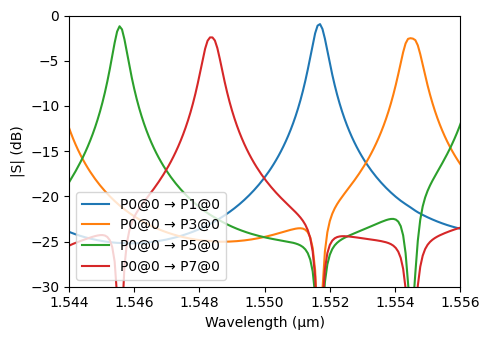

In [11]:
# Compute the S-matrix of the 1RR-based 4-channel multiplexer
s_matrix_mux_1rr = mux_1rr.s_matrix(frequencies=pf.C_0 / wavelengths)

# Plot the S-matrix with input from port P0 in dB scale
fig, axes = pf.plot_s_matrix(
    s_matrix_mux_1rr, y="dB", input_ports=["P0"], output_ports=["P1", "P3", "P5", "P7"]
)

# Adjust plot limits to highlight relevant spectral region
axes[0].set_ylim([-30, 0])
axes[0].set_xlim([1.544, 1.556])

# Set legend location for better visibility
axes[0].legend(loc="lower left")

### The 2RR Double-Ring Resonator Filter

We define a double-ring resonator (2RR) filter by assembling directional couplers, waveguide bends, and straight waveguide segments. The couplers include bus-to-ring and ring-to-ring configurations, each with distinct coupling gaps. The layout includes bond pads designed to facilitate electrical connectivity and thermal tuning, closely replicating the design from the referenced paper.


In [12]:
@pf.parametric_component
def filter_2rr(
    *,  # Parameters for 2RR filter construction
    coupling_length=9.0,  # Directional coupler length (µm)
    radius=5,  # Ring radius (µm)
    rr_gap=0.340,  # Ring-to-ring coupling gap (µm)
    br_gap=0.205,  # Bus-to-ring coupling gap (µm)
    pad_width=10  # Bond pad width (µm)
):
    # Directional coupler for ring-to-ring configuration
    dc_2rr = directional_coupler(
        coupling_gap=rr_gap, radius=radius, coupling_length=coupling_length
    )

    # Directional coupler for bus-to-ring configuration
    dc_2br = directional_coupler(
        coupling_gap=br_gap,
        radius=radius,
        coupling_length=coupling_length,
        type="bus_to_ring",
    )

    # Netlist for assembling the 2RR resonator
    netlist_2RR = {
        "name": "cascaded_ring_filter",
        "instances": {
            "bus_coupler0": dc_2br,
            "bus_coupler1": dc_2br,
            "ring_coupler0": dc_2rr,
            "bend0": bend,
            "bend1": bend,
            "wg0": wg,
            "wg1": wg,
            "wg2": wg,
        },
        "connections": [
            (("ring_coupler0", "P0"), ("bus_coupler0", "P1")),
            (("bus_coupler1", "P3"), ("ring_coupler0", "P1")),
            (("bend0", "P0"), ("bus_coupler0", "P0")),
            (("bend1", "P1"), ("bus_coupler0", "P2")),
            (("wg0", "P1"), ("bend0", "P1")),
            (("wg1", "P1"), ("bus_coupler1", "P2")),
            (("wg2", "P1"), ("bend1", "P0")),
        ],
        "ports": [
            ("wg0", "P0"),  # Input port
            ("wg1", "P0"),  # Drop port
            ("wg2", "P0"),  # Add port
            ("bus_coupler1", "P0"),  # Through port
        ],
        "models": [pf.CircuitModel()],
    }

    # Create the 2RR component from the netlist
    two_rr = pf.component_from_netlist(netlist_2RR)

    # Calculate bond pad and connecting rectangle positions based on coupler ports
    p0_center = np.array(dc_2br.ports["P0"].center)
    p1_center = np.array(dc_2br.ports["P1"].center)
    p2_center = np.array(dc_2br.ports["P2"].center)
    p3_center = np.array(dc_2br.ports["P3"].center)

    # Create first bond pad (M1 layer) near port P0
    bp1 = pf.Rectangle(center=p0_center, size=(pad_width, 2 * pad_width))
    bp1.x_max = p0_center[0] + pad_width / 2.0 - 1.2 - 0.5
    bp1.y_max = p0_center[1] - pad_width / 2.0

    # Connecting rectangle from pad1 to coupler vias
    rect1 = pf.Rectangle(center=p0_center, size=(pad_width / 4.0, pad_width * 4))
    rect1.x_max = bp1.x_max
    rect1.y_min = bp1.y_max

    # Second bond pad (M1 layer) near port P3
    bp2 = bp1.copy()
    bp2.x_min = p3_center[0] - pad_width / 2.0 + 1.2 + 0.5
    bp2.y_min = p3_center[1] + pad_width / 2.0 + 4 * radius

    # Connecting rectangle from pad2 to coupler vias
    rect2 = rect1.copy()
    rect2.x_min = bp2.x_min
    rect2.y_max = bp2.y_min

    # Add bond pads and connecting rectangles to the 2RR component
    two_rr.add("M1", bp1, rect1, bp2, rect2)

    return two_rr  # Return the constructed 2RR component


# Instantiate and visualize the double-ring filter layout
two_rr = filter_2rr()
viewer(two_rr)

Loading cached simulation from .tidy3d/pf_cache/25H/fdtd_info-SLATWU7PFJQXVWNI2JNKFWSTNSSSZ4QZKFOI6VYUIX7XDB2I57WQ.json.


Loading cached simulation from .tidy3d/pf_cache/25H/fdtd_info-DNHOITSMGE4WLRIFJ546FXE5FAMHFKY325BCFL4UTKWN6HXECUIA.json.
Loading cached simulation from .tidy3d/pf_cache/25H/fdtd_info-EAJBXBQ4NWQEBMJ6MUTAQKBHBEIQ4V6UWT6DZU4UUP7TJUGKMN4Q.json.
Loading cached simulation from .tidy3d/pf_cache/25H/fdtd_info-6YXJGLCYOTMPXLTNQFT3ZNS2YPPNQSMSD5SS4E6ZOTMDIGWC6CQQ.json.


Loading cached simulation from .tidy3d/pf_cache/SW3/fdtd_info-4NOSQSP7PF3P36GEFSWQWE3SK27DYYOOFJESRI44VHEBKRK3R75Q.json.


Progress: 100% 


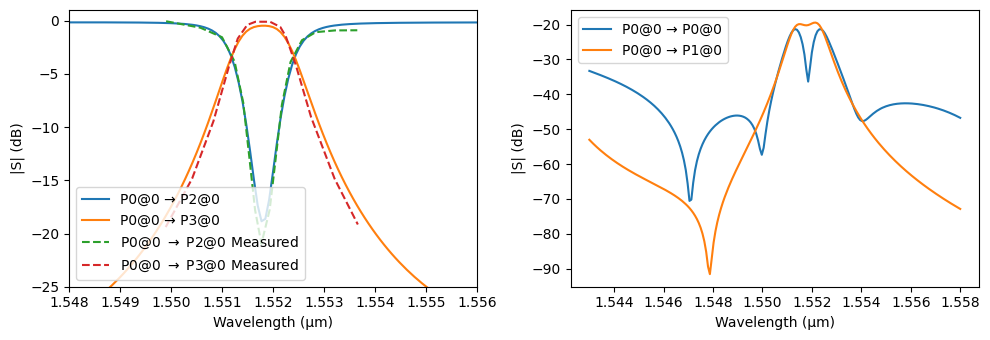

In [13]:
# Measurement data for 2RR filter
s20_measured = np.array(
    [
        [1.547004, -0.059],
        [1.547676, -0.665],
        [1.548100, -1.556],
        [1.548347, -3.848],
        [1.548517, -7.721],
        [1.548641, -13.056],
        [1.548749, -17.805],
        [1.548873, -20.973],
        [1.549035, -17.755],
        [1.549151, -13.013],
        [1.549274, -7.919],
        [1.549444, -3.881],
        [1.549668, -1.836],
        [1.549938, -1.083],
        [1.550317, -0.918],
        [1.550753, -0.905],
    ]
)
s30_measured = np.array(
    [
        [1.546996, -19.395],
        [1.547514, -14.840],
        [1.547931, -9.461],
        [1.548239, -4.255],
        [1.548409, -1.682],
        [1.548595, -0.399],
        [1.548757, -0.103],
        [1.549042, -0.105],
        [1.549243, -0.593],
        [1.549351, -1.475],
        [1.549544, -4.118],
        [1.549846, -9.049],
        [1.550309, -14.863],
        [1.550764, -19.154],
    ]
)

# Compute the S-matrix of the 2RR double-ring resonator filter
s_matrix_2rr = two_rr.s_matrix(frequencies=pf.C_0 / wavelengths)

# Plot the S-matrix with input from port P0, showing response in dB
fig, axes = pf.plot_s_matrix(s_matrix_2rr, y="dB", input_ports=["P0"])

# Overlay measurement data with dashed line
# The resonance wavelength is shifted to match simulation
axes[0].plot(
    s20_measured[:, 0] + 0.0029,
    s20_measured[:, 1],
    "--",
    label=r"P0@0 $\rightarrow$ P2@0 Measured",
)
axes[0].plot(
    s30_measured[:, 0] + 0.0029,
    s30_measured[:, 1],
    "--",
    label=r"P0@0 $\rightarrow$ P3@0 Measured",
)

axes[0].set_xlim([1.548, 1.556])
axes[0].set_ylim([-25, 1])
axes[0].legend(loc="lower left")

### Assembling a 4-Channel 2RR-Based WDM Multiplexer

We construct a four-channel multiplexer by cascading four double-ring resonators (2RRs) with progressively increased coupling lengths to achieve distinct resonance frequencies for each channel. Waveguide segments interconnect the resonators to form a complete multiplexer structure, as specified in the referenced design.


In [14]:
# Define the base coupling length and incremental length for each channel
added_length = 0.075
coupling_length = 9

# Instantiate four double-ring resonators (2RR) with incremental coupling lengths
two_rr_0 = filter_2rr(coupling_length=coupling_length)
two_rr_1 = filter_2rr(coupling_length=coupling_length + added_length)
two_rr_2 = filter_2rr(coupling_length=coupling_length + 2 * added_length)
two_rr_3 = filter_2rr(coupling_length=coupling_length + 3 * added_length)

# Netlist defining the 4-channel multiplexer based on 2RR resonators
netlist = {
    "name": "4-Channel MUX 2RR",
    "instances": {
        "2rr0": two_rr_0,  # First resonator (channel 0)
        "2rr1": two_rr_1,  # Second resonator (channel 1)
        "2rr2": two_rr_2,  # Third resonator (channel 2)
        "2rr3": two_rr_3,  # Fourth resonator (channel 3)
        "wg": wg,  # Output waveguide after resonator 3
    },
    "connections": [
        (("2rr1", "P1"), ("2rr0", "P3")),  # Connect resonator 1 to resonator 0
        (("2rr2", "P1"), ("2rr1", "P3")),  # Connect resonator 2 to resonator 1
        (("2rr3", "P1"), ("2rr2", "P3")),  # Connect resonator 3 to resonator 2
        (("wg", "P0"), ("2rr3", "P3")),  # Connect final resonator output to wg3
    ],
    "ports": [
        ("2rr0", "P1"),  # Multiplexer input
        ("2rr0", "P0"),
        ("2rr0", "P2"),
        ("2rr1", "P0"),
        ("2rr1", "P2"),
        ("2rr2", "P0"),
        ("2rr2", "P2"),
        ("2rr3", "P0"),
        ("2rr3", "P2"),
        ("wg", "P1"),  # Final through output
    ],
    "models": [pf.CircuitModel()],
}

# Assemble the multiplexer component from the netlist
mux_2rr = pf.component_from_netlist(netlist)

viewer(mux_2rr)

Loading cached simulation from .tidy3d/pf_cache/PUV/fdtd_info-2DCRNSDI6PM5OLH6XIFMEYNDFDANJ627ANV54UGRHCQYMX62FNXA.json.
Loading cached simulation from .tidy3d/pf_cache/PUV/fdtd_info-ORKEAESJ6VM4ETF2MU5YDDBJD3KQCPWXVJE6GNABYHBMKNRH5CLQ.json.
Loading cached simulation from .tidy3d/pf_cache/PUV/fdtd_info-SXADHOUDPZYD2V62GWP6RVJKJJPHSK35DOZJAZJZ3XQZMMYI3K2Q.json.


Loading cached simulation from .tidy3d/pf_cache/PUV/fdtd_info-YR4N5HXVCASLLJHSV7ZJSUTC5HY6Z6C72ZQXBNO5F2K63YLK2ISQ.json.


Loading cached simulation from .tidy3d/pf_cache/OTB/fdtd_info-LUENRGWN7TJQRMXK4K2ALOYEDA4ZVQAKQYWFGNC7YLVPQ5ABLQ5A.json.


Loading cached simulation from .tidy3d/pf_cache/VZF/fdtd_info-AS3ZIIDW45BN55X2OR7DO2JQEZOD64REFKNJP2F24WUL6NDJRS7A.json.
Loading cached simulation from .tidy3d/pf_cache/VZF/fdtd_info-TBUMRTOC3HHIARV6ZGSB5R3EDZJNBQBU6OX6GCV27PHHU377KCEQ.json.
Loading cached simulation from .tidy3d/pf_cache/VZF/fdtd_info-2AX5XUPXMXDUL5BLFOY2WNKSYVIA3HO54C4KXT2QT54X5AAX376A.json.


Loading cached simulation from .tidy3d/pf_cache/VZF/fdtd_info-DHUBX3MRDK3XPHPKZ4AXGZ5VDHMTQLNM45SFUY3ITRIRM5WKMOFQ.json.
Loading cached simulation from .tidy3d/pf_cache/FB5/fdtd_info-CRS64PKG5CF6HAKEEEKCWPXAOI6725MC35XXCNS2QNUKH2I7ZRVA.json.


Loading cached simulation from .tidy3d/pf_cache/4PQ/fdtd_info-TERB3JE4JCISDUM3R35XUOZO33Q3RZYRALTTAU6IVFPXWTHFIHVA.json.
Loading cached simulation from .tidy3d/pf_cache/4PQ/fdtd_info-VCJDQRXBMHMVMBAFAOCKWJW5XWCL2OJEQO3O3OVTF5B3LIPI3RFQ.json.
Loading cached simulation from .tidy3d/pf_cache/4PQ/fdtd_info-KAU3N2OBZWQCEJLSEI6RSULPS5ZLW3LWCXXC4PXW7GSUZBWTF64A.json.
Loading cached simulation from .tidy3d/pf_cache/4PQ/fdtd_info-PWPWWFCAWAECIJRW5RC5UNM6WD2YR2ABUMF4A22VKOKGILSJAM3A.json.


Loading cached simulation from .tidy3d/pf_cache/CFR/fdtd_info-46AQGYPWCDM54D6CLSSUIYGJRRPDMBNXWKG3PCKB6NTSEKRTG3GA.json.


Loading cached simulation from .tidy3d/pf_cache/WAU/fdtd_info-XN3C5BX56YZT23MSNGNBJZVDMJKROZCXUSO3BRFXQELB6OG5XIBA.json.
Loading cached simulation from .tidy3d/pf_cache/WAU/fdtd_info-7I7KINXLRCS3GJ5MNRSIFTNZNBKXYMAV53F6SKLYH75XXPRQZHFA.json.


Loading cached simulation from .tidy3d/pf_cache/WAU/fdtd_info-QE3RBQHRWMZELNSOO63BVMTMBTHDC4AKDGO4HVHYWHB67U5I34LQ.json.
Loading cached simulation from .tidy3d/pf_cache/WAU/fdtd_info-X7M5XEMM3TVOCWU5JTBN2Q4B7MWSTSN7TQBOW72E4HKIFQNUPDRQ.json.


Loading cached simulation from .tidy3d/pf_cache/UGV/fdtd_info-6K5M32BDYVGRST6FAYQ7DKCYSTNJKWXICLUAXWKFLFKWS76DTHAA.json.


Progress: 100% 


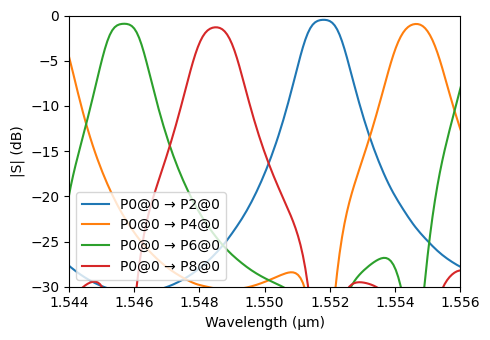

In [15]:
# Compute the S-matrix for the 4-channel 2RR-based multiplexer
s_matrix_mux_2rr = mux_2rr.s_matrix(frequencies=pf.C_0 / wavelengths)

# Plot the multiplexer spectral response with input from port P0
fig, axes = pf.plot_s_matrix(
    s_matrix_mux_2rr, y="dB", input_ports=["P0"], output_ports=["P2", "P4", "P6", "P8"]
)

# Set plot limits to focus on the relevant spectral region
axes[0].set_ylim([-30, 0])
axes[0].set_xlim([1.544, 1.556])

# Position legend clearly in lower-left corner
axes[0].legend(loc="lower left")